# マルチメディア画像処理 レポート課題2
## 課題内容
1. 教科書P.85式(4.2)で表されるトーンカーブ変換（γ変換）を実行するプログラムを作成しなさい。また、作成したプログラムを適当な濃淡画像に適用し正しく実行されていることを確認しなさい。

2. 図4．21 -- 図4.23のようなαブレンディングを実行するプログラムを作成し、作成したプログラムを適当なカラー画像2枚に適用し正しく実行されていることを確認しなさい。（同じサイズの画像を使うと楽ちん。）

3. 適当な１枚の画像を中心軸に関して左右反転させてみよ。

4. 適当な１枚の画像を３ｘ３のモザイク状に区切って、各モザイクを順番にもしくはランダムに選んで５秒おきに左右反転させてみよ。

### 画像の読み込み

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt

import numpy as np
import cv2

plt.style.use("ggplot")

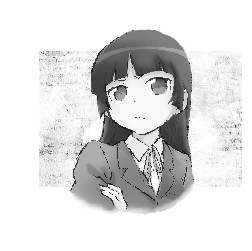

In [2]:
gray_img = cv2.imread("../fig/rep1/kuroneko_1.jpg", cv2.IMREAD_GRAYSCALE)
#show_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.axis("off")
plt.imshow(gray_img, cmap="gray")

上記の画像データを元に画像処理を行っていく

### 課題1 トーンカーブ変換($\gamma$変換)
#### ソースコード

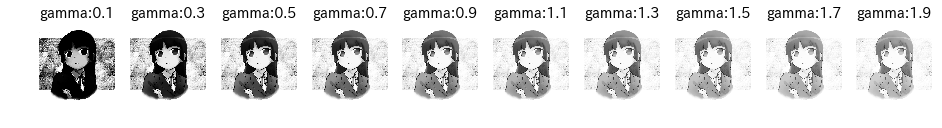

In [3]:
gamma = np.arange(0.1, 2.1, 0.2)
fig, ax = plt.subplots(ncols = len(gamma), figsize=(16,8))

for i, gam in enumerate(gamma):
    gamma_img = gray_img.max() * np.power((gray_img / gray_img.max()), (1 / gam))
    ax[i].set_title("gamma:{}" .format(round(gam,2)))
    ax[i].imshow(gamma_img, cmap="gray")
    ax[i].axis("off")

__考察__

今回使用したトーンカーブ変換($\gamma変換$)は、累乗型のトーンカーブを採用しており、折れ線型のトーンカーブでは変換した際の性質の急激な変更を補うようなアルゴリズムになっている。  
入力画像の画素値を$x$とし、出力画像の画素値をyとするとき、トーンカーブは以下の式で表される。

$$y = 255 \cdot \left( \frac{x}{255} \right) ^\frac{1}{\gamma}$$

またガンマ値を変更することによるトーンカーブは以下のようになる。

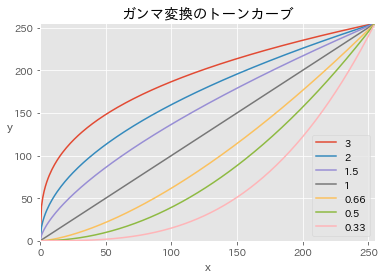

In [4]:
for gamma in [3,2,1.5,1,0.66,0.5,0.33]:
    x = np.arange(0,255,1)
    y = 255 * (x/255) ** (1/gamma)
    plt.plot(x,y)
    plt.legend([3,2,1.5,1,0.66,0.5,0.33])
    plt.title("ガンマ変換のトーンカーブ")
    plt.xlabel("x")
    plt.ylabel("y", rotation=0)
    plt.xlim(0,255)
    plt.ylim(0,255)

このような変換は__ガンマ変換__または__ガンマ補正__と呼ばれている。

### 課題2 $\alpha$ブレンディング
#### ソースコード(画像処理部)

In [5]:
# 画像の読み込みと色変換
img_1 = cv2.imread("../fig/rep2/jusen-piar1.jpg")
img_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB)

img_2 = cv2.imread("../fig/rep2/jusen-piar2.jpg")
img_2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2RGB)

# 4-21.画素値の平均を取る画像を生成
img_ab = cv2.addWeighted(img_1, 0.5, img_2, 0.5, 0.0)

# 4-22.αを画像位置で変化させる
img_ab_chg = []
width = len(img_1[0])
height = len(img_1)

for i in range(width):
    a1 = 1 - (1/width * i)
    a2 = 1/width * i
    
    out = a1 + a2 * (1 - a1)
    img_ab_chg.append((img_1[:,i] * a1 + img_2[:,i] * a2) / out) 

img_ab_chg = np.array(img_ab_chg).transpose(1,0,2)

# 4-23.αを時間で変化させる
fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
video = cv2.VideoWriter('img_ab.mp4', fourcc, 30.0, (320, 236))

for i in range(1, 101):
    img = cv2.addWeighted(img_1, i/100, img_2, 1-(i/100), 0.0)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    video.write(img) 
video.release()

#### ソースコード(出力部)

(-0.5, 319.5, 235.5, -0.5)

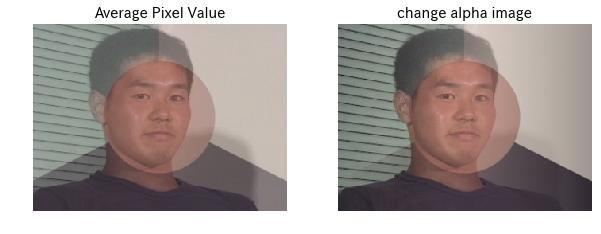

In [6]:
fig,ax = plt.subplots(ncols=2, figsize=(10,12))

ax[0].set_title("Average Pixel Value")
ax[0].imshow(img_ab)
ax[0].axis("off")

ax[1].set_title("change alpha image")
ax[1].imshow(img_ab_chg / 320)
ax[1].axis("off")

αブレンドを時間で変化させた動画は以下のリンクにアップロードしてあるのでそこから確認できる。

> https://ie.u-ryukyu.ac.jp/~e155727/MMImageProcess/img_ab.mp4

__考察__

今回使用したアルファブレンディングと言う手法は__画像間演算__の一つで
具体的には2枚の画像で重み付き平均を計算している。この処理を__アルファブレンディング__と呼び、
以下の式で示される。

$$g = \alpha f_1 + (1- \alpha)f_2$$ 
$$(但し,\alphaは(0 \leq \alpha \leq 1))$$

上記の課題はそれぞれ

1. $\alpha=0.5$として2枚を平均で重ねた画像
2. $\alpha=列位置/画像の横幅$として2枚を平均で重ねた画像
3. $\alpha=時間$として2枚を平均で重ねた画像

を行っている。特に3のような手法を__ディゾルブ__や__オーバーラップ__と呼ばれている。

### 課題3. 中心軸で左右反転

#### ソースコード(画像処理部)

In [7]:
img_1_l = img_1[:, :int(width/2)]
img_1_r = img_1[:, int(width/2):-1]
img_1_ll = np.hstack((img_1_l, cv2.flip(img_1_l, 1)))
img_1_rr = np.hstack((cv2.flip(img_1_r, 1), img_1_r))

#### ソースコード(出力部)

(-0.5, 319.5, 235.5, -0.5)

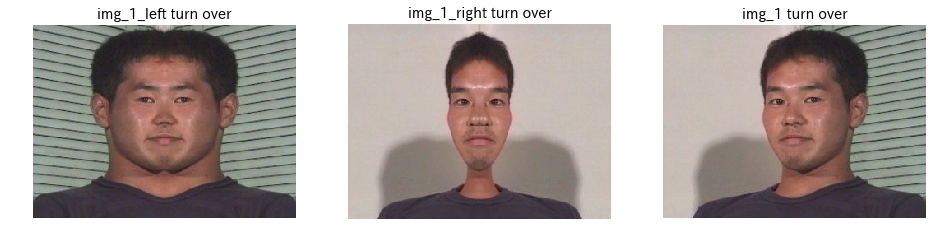

In [8]:
fig,ax = plt.subplots(ncols=3, figsize=(16,12))

ax[0].set_title("img_1_left turn over")
ax[0].imshow(img_1_ll)
ax[0].axis("off")

ax[1].set_title("img_1_right turn over")
ax[1].imshow(img_1_rr)
ax[1].axis("off")

ax[2].set_title("img_1 turn over")
ax[2].imshow(cv2.flip(img_1,1))
ax[2].axis("off")

### 課題4 3x3のモザイク状に区切って、各モザイクを順番にもしくはランダムに選んで５秒おきに左右反転
画像処理確認のため5秒ではなく、0.5秒毎に反転処理を行う。

#### ソースコード

In [9]:
fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
fps = 30
video = cv2.VideoWriter('img_mo.mp4', fourcc, fps, (320, 236))
img_mo = cv2.cvtColor(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), cv2.COLOR_BGR2RGB)

x, y = 0, 0
for i in range(1, int(fps/2) * 9 + 1):
    if i %int(fps/2) == 0:
        img_mo[int(height * y / 3):int(height * (y+1)/3), int(width * x / 3):int(width * (x+1)/3)] = cv2.flip(img[int(height * y / 3):int(height * (y+1)/3), int(width * x / 3):int(width * (x+1)/3)], 1)
        x += 1
        if x == 3:
            x = 0
            y += 1
    video.write(img_mo) 
video.release()

時間毎に一定の位置の左右を反転させた動画も同様に、以下のリンクにアップロードしてあるのでそこから確認できる。

> https://ie.u-ryukyu.ac.jp/~e155727/MMImageProcess/img_mo.mp4

### 総考察
+ 今回の課題にてそれぞれの処理に対して、OpenCVに標準搭載されている関数が役に立っていたが、それ以上に行列計算が多用されていることが実感できた。
    + 特にアルファブレンディングを一定方向に変化させたり、時間毎にある一定の行もしくは列をさせるために行列計算を行った。
+ 画像処理の中でも今回は画素ごとの濃淡変換について行い、そのアルゴリズムや画像への影響を理解することができた。

## 参考文献

+ 機械学習のデータセット画像枚数を増やす方法
> https://goo.gl/bBERjd